# Dog Breeds Image Classifier
### This model can recognize five different dog breeds: Siberian Husky, Shih Tzu and Pug!


 We first make the set up of the notebook and import some libraries 

In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
from fastbook import *
from fastai.vision.widgets import *
from zipfile import ZipFile
import requests
import urllib.request

### Downloading and extracting the dataset

Using the variable 'dog_breeds' we set up all the categories that our model can predict, and then we download directly from the [GitHub repository of our project](https://github.com/OhLK/Project-LE530) the dataset containing images of the three different breeds of dog. After downloading the dataset, we use a function to extract it, because it is downloaded as a '.zip' file.

In [6]:
dog_breeds = 'siberian_husky','shih_tzu','pug'

path = URLs.path('dataset')
if not path.exists():
    path.mkdir(parents=true)

url = 'https://codeload.github.com/OhLK/Project-LE530/zip/refs/heads/main'
r = requests.get(url)

with open(path/'dataset.zip', "wb") as code:
    code.write(r.content)

urllib.request.urlretrieve(url)

with ZipFile(path/'dataset.zip', 'r') as zipObj:
   zipObj.extractall(path)

path = path/'Project-LE530-main/dataset'
path.ls()

(#3) [Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/pug'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/siberian_husky')]

Now we check if there are some corrupted images in our dataset and then remove them.

In [7]:
fns = get_image_files(path)
fns

(#296) [Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000056.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000008.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000034.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000000.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000076.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000063.jpeg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000055.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000013.jpg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000096.jpeg'),Path('/root/.fastai/archive/dataset/Project-LE530-main/dataset/shih_tzu/00000086.jpg')...]

In [8]:
failed = verify_images(fns)
warnings.filterwarnings("ignore", "(Possibly )?Corrupt EXIF data", UserWarning)

In [9]:
failed.map(Path.unlink)

(#0) []

### Creating a DataBlock and a DataLoader

In [10]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42), #30% to the validation set, random image distribution
    get_y=parent_label,
    item_tfms=Resize(128))

After creating the `DataBlock` above, we create a `DataLoader` to hold our data and suplly us with usefull functions.

In [11]:
dls = dogs.dataloaders(path)

Now, we can check what is inside of our `DataLoader`. Let's see a batch with fifteen images from our valid dataset.

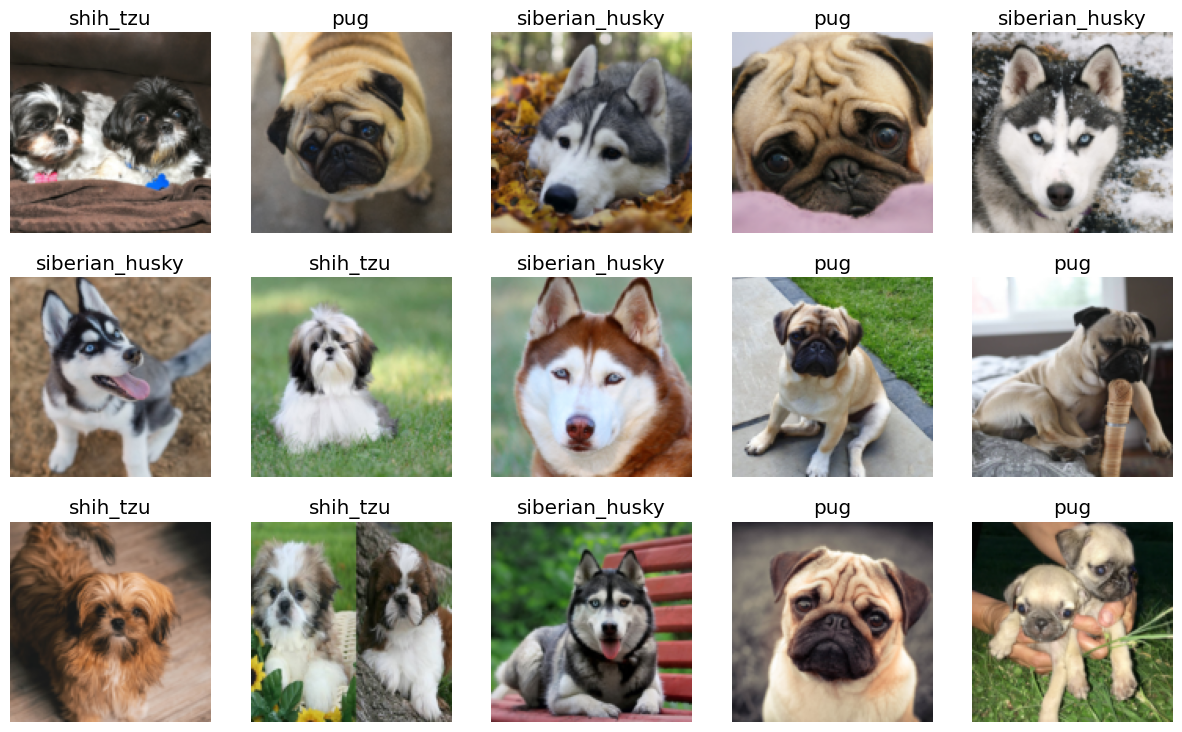

In [12]:
dls.valid.show_batch(max_n=15, nrows=3)

###Doing image augmentation

Here is an example of image augmentation using `aug_transforms`.

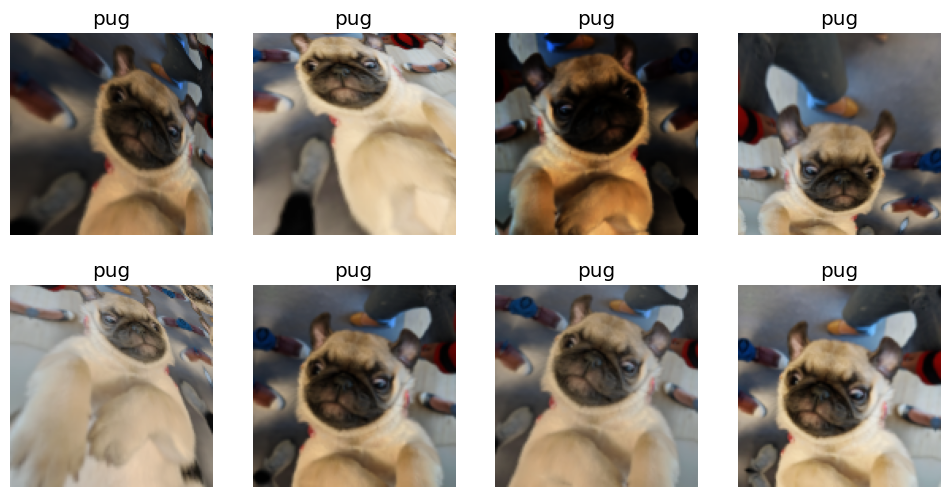

In [13]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Below we apply `aug_transforms `to our whole dataset. That's a good thing to do because the model will train with more varied image positions, quality, and angles.

In [14]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

### Training our model

We already have preperad our data and now we're ready to train our model!

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd

### Checking the results after the training process

We use the confusion matrix to see the results of our model and check if it has done some wrong predictions.

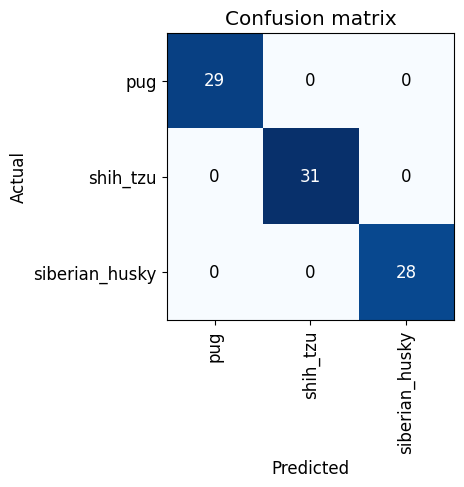

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Now we can plot the predictions with the higher loss and see if there are some images with wrong labels or images that simply shouldn't be in our dataset.

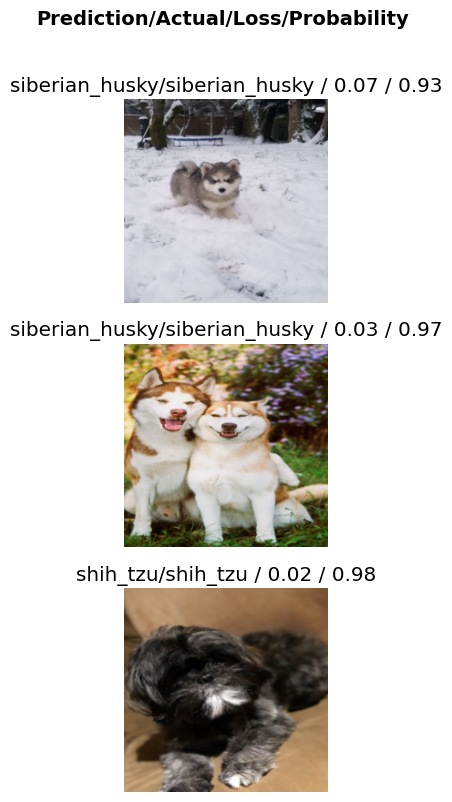

In [17]:
interp.plot_top_losses(3, nrows=3)

Above our model has helped us to see if there are images that shouldn't be in our dataset using `interp.plot_top_losses`. If we want, we can delete these images using the widget below.

In [18]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After cleaning our dataset using our model to help us, we can retrain our model and increase its accuracy.

###Exporting the trained model to a '.pkl' file

In [20]:
learn.export()

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [22]:
learn_inf = load_learner(path/'export.pkl')

After exporting the trained model to a '.pkl' file, we use it to predict what is the breed of the dog in the image below:

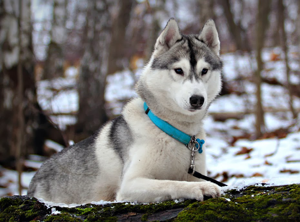

In [24]:
path = URLs.path('dataset')
path = path/'Project-LE530-main/dataset'

im = Image.open(path/'siberian_husky/00000087.jpg')
im.to_thumb(300,300)

In [26]:
learn_inf.predict(path/'siberian_husky/00000096.jpg')

('siberian_husky', tensor(2), tensor([3.8960e-06, 5.4893e-06, 9.9999e-01]))

It predicted right! It is a SIberian Husky, the tensor above show us the probabilty of the the image be of one of the five breeds.

In [27]:
learn_inf.dls.vocab

['pug', 'shih_tzu', 'siberian_husky']

The vocab is simply the categories that our model can recognize.